In [6]:
# to handle datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# for machine learning
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# for evaluation 
from sklearn.metrics import roc_auc_score

In [2]:
train_transaction_cols = ['TransactionID', 'C3', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V27', 'V28', 'V32', 'V98', 'V116', 'V117', 'V118', 'V119', 'V120', 'V153', 'V154', 'V157', 'V158', 'V235', 'V284', 'V286', 'V297', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V325', 'V327', 'V328', 'TransactionDT', 'TransactionAmt', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'V95', 'V96', 'V97', 'V99', 'V100', 'V101', 'V102', 'V126', 'V127', 'V145', 'V166', 'V279', 'V280', 'V285', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V298', 'V299', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V326', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'ProductCD', 'isFraud']

train_identity_cols = ['TransactionID', 'id_08', 'id_13', 'id_17', 'id_19', 'id_20', 'id_21', 'id_26', 'id_16', 'id_27', 'DeviceInfo']

In [3]:
# load data
train_transaction = pd.read_csv("/content/train_transaction.csv", usecols=train_transaction_cols)
train_identity = pd.read_csv("/content/train_identity.csv", usecols=train_identity_cols)

# merge the dataframe
dataframe = pd.merge(train_transaction,
                     train_identity,
                     how="left",
                     on="TransactionID")

In [4]:
dataframe.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,addr1,...,id_08,id_13,id_16,id_17,id_19,id_20,id_21,id_26,id_27,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,142.0,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,102.0,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,166.0,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,117.0,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,102.0,420.0,...,NaN,NaN,NotFound,166.0,542.0,144.0,NaN,NaN,NaN,SAMSUNG SM-G892A Build/NRD90M


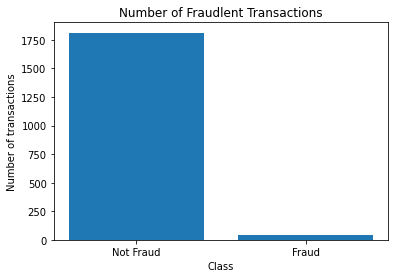

In [7]:
x = ["Not Fraud", "Fraud"]
height = list(dataframe["isFraud"].value_counts())

plt.bar(
    x= x,
    height= dataframe["isFraud"].value_counts()
)

plt.title("Number of Fraudlent Transactions")
plt.xlabel("Class")
plt.ylabel("Number of transactions") 
plt.show()

In [ ]:
# convert numeric features to object
# to follow the documentation 
numeric_cat_cols = ["card1", "card2", "card3", "card5", "addr1", "addr2", "id_13",
                    "id_17", "id_19", "id_20", "id_21", "id_26"]

cat_cols = list(dataframe.select_dtypes(include=['object']).columns)
cat_cols += numeric_cat_cols 

dataframe[cat_cols] = dataframe[cat_cols].astype("O")

# collecting all of the numerical features 
num_cols = [x for x in dataframe.select_dtypes(include=['number']).columns
            if x not in cat_cols
            if x not in "isFraud"]

# collecting all of the features with missing values
features_with_na = [x for x in dataframe.columns if dataframe[x].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
missing_vals_df = pd.DataFrame(
    dataframe[features_with_na].isnull().mean().sort_values(ascending=False),
    columns=["percentage"]
)

# seperating features with missing
# values to categorical and numeric
cat_feat_with_na = [x for x in cat_cols if x in features_with_na]
num_feat_with_na = [x for x in num_cols if x in features_with_na]

# features to remove
drop_features = [col for col in 
                 list(missing_vals_df.iloc[np.where(missing_vals_df.loc[cat_feat_with_na, 'percentage'] > 0.5)].index)]

drop_features += [col for col in
                  list(missing_vals_df.iloc[np.where(missing_vals_df.loc[num_feat_with_na, 'percentage'] > 0.5)].index)]

# defining the different features 
discrete_features = [x for x in num_cols 
                     if len(dataframe[x].unique()) < 20
                     and x not in drop_features]

continuous_features = [x for x in num_cols
                       if x not in discrete_features + drop_features + ["TransactionID"]]

high_cardinality_cats = ["R_emaildomain", "card1", "card2", "card3",
                         "card5", "addr1", "addr2", "id_13", "id_17", "id_19", "id_20",
                         "id_21", "id_26"]

categorical_features = [x for x in cat_cols if x not in drop_features + high_cardinality_cats]

all_features = discrete_features + continuous_features + high_cardinality_cats + categorical_features

impute_freq = high_cardinality_cats + categorical_features + discrete_features

cat_codes_cols = high_cardinality_cats + categorical_features

In [ ]:
from collections import Counter, defaultdict
from typing import List, Union

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AggregateCategorical(BaseEstimator, TransformerMixin):
    
    #Reduces the cardinality of categorical features
    #Credit: Raj Sangani- https://bit.ly/3BSxdTX


    def __init__(self, features: List[Union[str, int]], threshold: float = 0.75):
        if not isinstance(features, list) or len(features) == 0:
            raise ValueError("Was expecting a list of features")
        self.features = features
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        threshold_value = int(self.threshold * len(X))
        df = X.copy()
        
        self.agg_values_ = defaultdict(list)
        for col in self.features:
            counts = Counter(df[col])
            s = 0
            # Loop through the category name and its corresponding frequency
            for i, j in counts.most_common():
                s += counts[i]
                self.agg_values_[col].append(i)
                
                if s >= threshold_value:
                    break
        return self

    def transform(self, X: pd.DataFrame):
        df = X.copy()
        for col in self.features: 
            df[col] = df[col].apply(lambda x: x if x in self.agg_values_[col] else "other")
        return df


class MostFrequentImputer(BaseEstimator, TransformerMixin):
    #A wrapper around `SimpleImputer` to return data frames with columns.
    #Credit: https://bit.ly/3r2N40k

    def __init__(self, features):
        if not isinstance(features, list) or len(features) == 0:
            raise ValueError("Was expecting a list of features")
            
        self.features = features
        
    def fit(self, X, y=None):
        self.imputer_dict_ = {}
        for feature in self.features:
            self.imputer_dict_[feature] = X[feature].mode()[0]
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].fillna(self.imputer_dict_[feature])      
        return X
    
class MeanImputer(BaseEstimator, TransformerMixin):
    
    #Credit: https://bit.ly/3r2N40k

    def __init__(self, features):
        if not isinstance(features, list) or len(features) == 0:
            raise ValueError("Was expecting a list of features")
        
        self.features = features

    def fit(self, X, y=None):
        self.imputer_dict_ = {}
        for feature in self.features:
            self.imputer_dict_[feature] = X[feature].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature].fillna(self.imputer_dict_[feature], inplace=True)
        return X
    
class CategoryConverter(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        if not isinstance(features, list) or len(features) == 0:
            raise ValueError("Was expecting a list of features")
            
        self.features = features
        
    def fit(self, X, y=None):
        self.codes_ = {}
        for feature in self.features:
            X[feature] = X[feature].astype("category")
            self.codes_[feature] = dict(zip(X[feature].values, X[feature].cat.codes))
            self.codes_[feature].update({np.nan:-1})
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            for val in X[feature].unique():
                if val not in self.codes_[feature]:
                    X[feature].replace(str(feature), -1, inplace=True)
            X[feature] = X[feature].map(self.codes_[feature])
        return X
    

In [ ]:
df1_ = dataframe.copy()

# seperate features and target
X = df1_[all_features]
y = df1_["isFraud"]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    stratify=y,
    random_state=25
)

# impute mode to high cardinality, categorical features,
imp_most_frequent = MostFrequentImputer(features=impute_freq)
imp_most_frequent.fit(X_train)
X_train = imp_most_frequent.transform(X_train)
X_test = imp_most_frequent.transform(X_test)

# aggregate the high cardinality categoricals so they have less dimensions
aggregate_categoricals = AggregateCategorical(high_cardinality_cats)
aggregate_categoricals.fit(X_train)
X_train = aggregate_categoricals.transform(X_train)
X_test = aggregate_categoricals.transform(X_test)

# convert all categorical features to type category and use codes
transform_dtype = CategoryConverter(features=cat_codes_cols)
transform_dtype.fit(X_train)
X_train = transform_dtype.transform(X_train)
X_test = transform_dtype.transform(X_test)

# impute the mean to the continuous features
imp_mean = MeanImputer(features=continuous_features)
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# modelling
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=25)
random_forest.fit(X_train, y_train)

train_preds = random_forest.predict_proba(X_train)
y_preds = random_forest.predict_proba(X_test)

preds_roc_auc_ = roc_auc_score(y_test, y_preds[:, 1])
train_roc_auc_ = roc_auc_score(y_train, train_preds[:, 1])

print(f"train ROC_AUC:{train_roc_auc_}\n\
test ROC_AUC: {preds_roc_auc_}")

In [ ]:
transactionAMTinput = input("enter amt")
transactionDTinput = input("enter date")
transactionIDinput = input("enter enter id")